In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from sklearn import datasets

from IPython.display import Image  
import pydotplus
from graphviz import Digraph

import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [3]:
wine = datasets.load_wine()
x = wine.data[:,[0,3]]
y = wine.target

In [4]:
y[y == 2] = 1

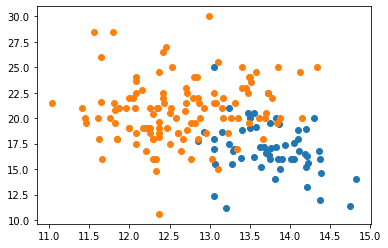

In [5]:
plt.scatter(x[:,0][y == 0.], x[:,1][y == 0.])
plt.scatter(x[:,0][y == 1.], x[:,1][y == 1.])
plt.show()

## Sklearn DecisionTreeClassifier

In [6]:
dt = DecisionTreeClassifier()
dt.fit(x,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

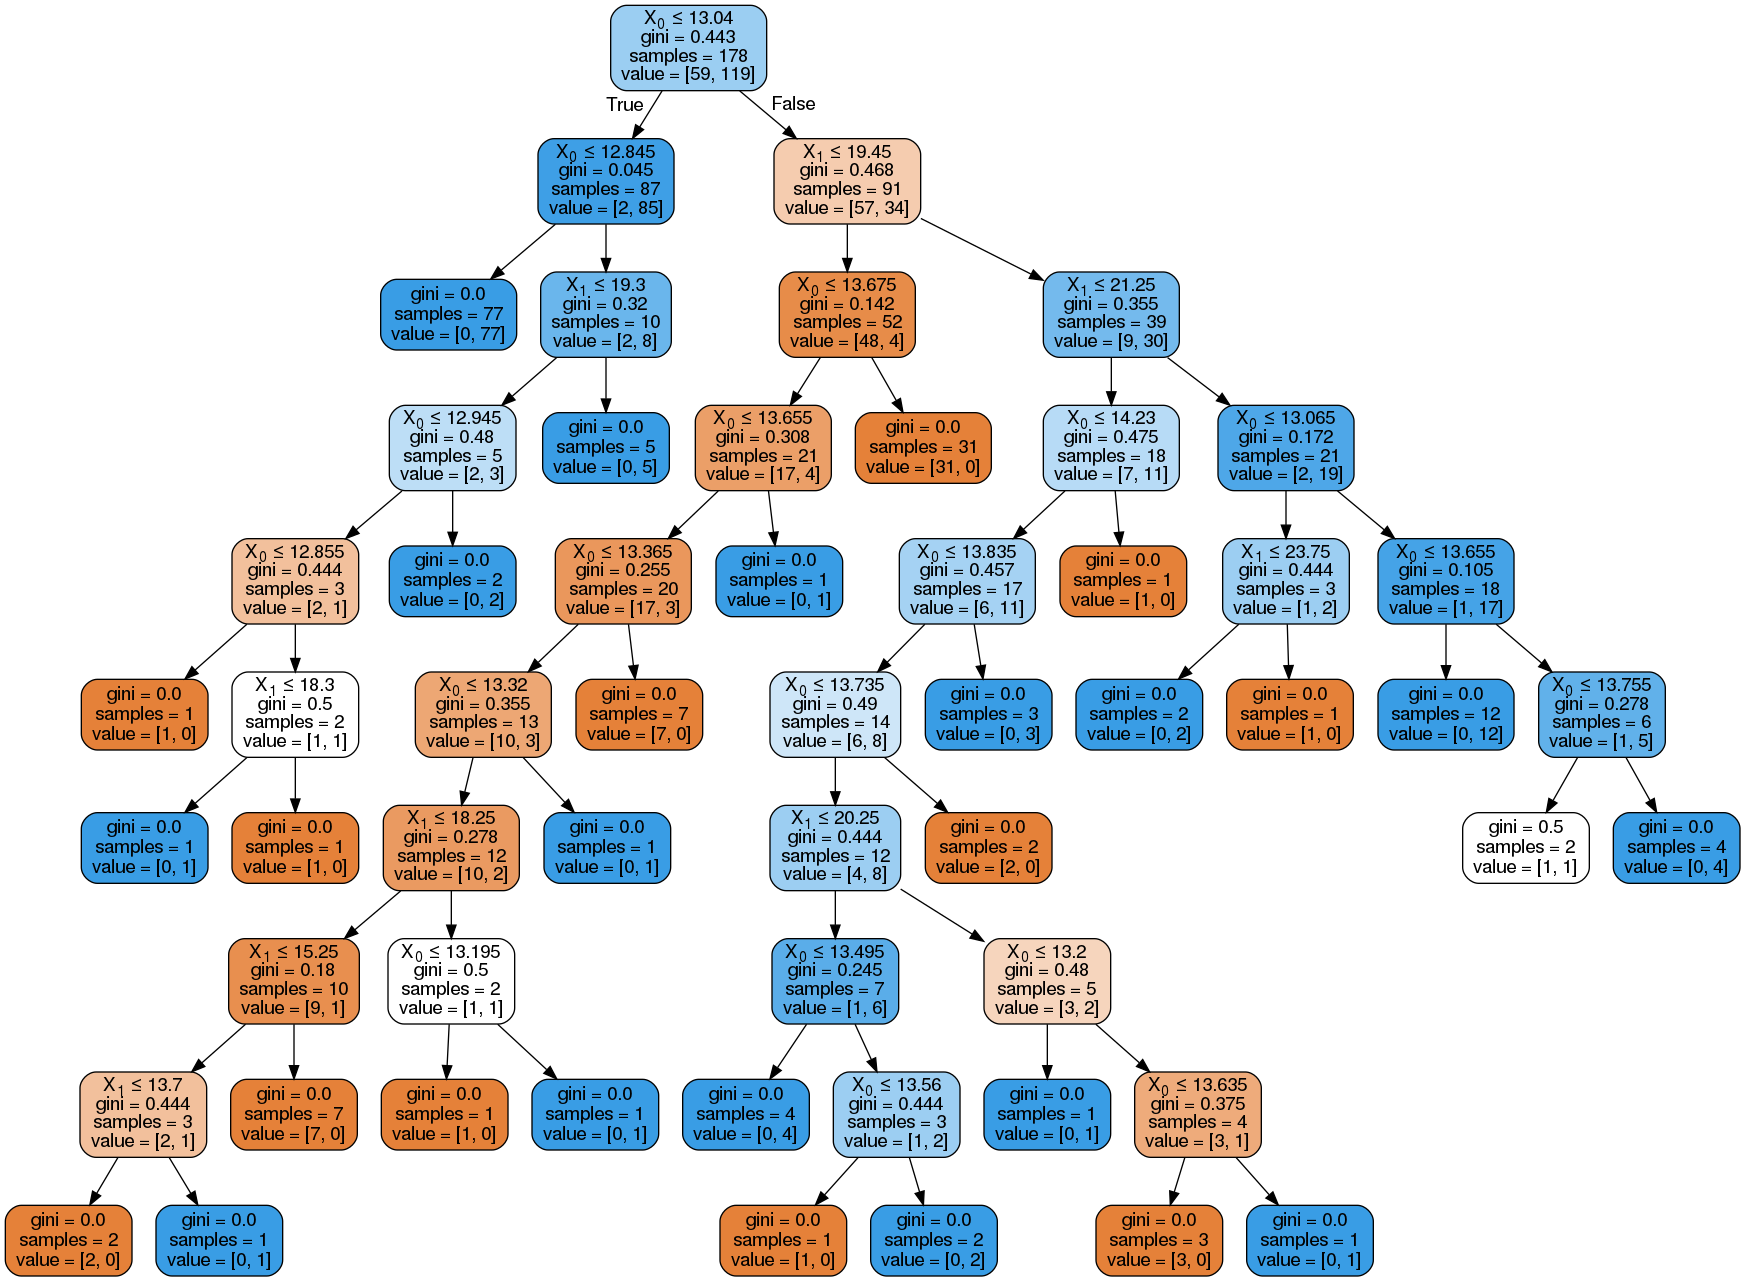

In [7]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Split node (error)

In [8]:
def error1(a):
    (v, c) = np.unique(a,return_counts = True)
    i = np.argmax(c)
    return v[i], np.sum(np.delete(c, i)), np.sum(c)

In [9]:
def error2(a1, a2 = None):
    c1, e1, t1 = error1(a1)
    c2, e2, t2 = (0, 0, 0) if a2 is None else error1(a2)
    return (e1 + e2) / (t1 + t2)

In [10]:
def split1(x, y):
    err = float('inf')
    dim = None
    psp = None

    for i in range(x.shape[1]):

        a = x[:,i]
        u = np.unique(a)
        u = (u[:-1] + u[1:]) / 2

        for p in u:
            e = error2(y[a < p], y[a > p])
            if err > e:
                err = e
                dim = i
                psp = p
    return (err, dim, psp)

In [11]:
split1(x,y)

(0.1797752808988764, 0, 13.495000000000001)

## Split node (gini)

In [12]:
def gini1(a):
    (v, c) = np.unique(a,return_counts = True)
    i = np.argmax(c)
    r = c/np.sum(c)
    return v[i], 1 - np.dot(r,r)

In [13]:
def gini2(a1, a2 = None):
    c1, g1 = gini1(a1)
    if a2 is None:
        return g1
    else:
        c2, g2 = gini1(a2)
        return (len(a1) / (len(a1) + len(a2))) * g1 + (len(a2) / (len(a1) + len(a2))) * g2

In [14]:
def split2(x, y):
    gin = float('inf')
    dim = None
    psp = None

    for i in range(x.shape[1]):

        a = x[:,i]
        u = np.unique(a)
        u = (u[:-1] + u[1:]) / 2

        for p in u:
            e = gini2(y[a < p], y[a > p])
            if gin > e:
                gin = e
                dim = i
                psp = p
    return (gin, dim, psp)

In [15]:
split2(x,y)

(0.2612441155641465, 0, 13.04)

## Decision Tree

In [16]:
def add_node(d, n, nid = '0'):
    if 'dim' in n:
        label = f'<X<SUB>{n["dim"]}</SUB> &le; {n["val"]:0.3f}<br/>class = {n["class"]}({1-n["err"]:0.2f})<br/>err = {n["err"]:0.3f}>'
    else:
        label = f'<class = {n["class"]}({1-n["err"]:0.2f})<br/>err = {n["err"]:0.3f}>'
    d.node(f'{nid}', label = label, fillcolor="#399de57f")
    if 'left' in n:
        add_node(d, n['left'], nid + '1')
        d.edge(f'{nid}', nid + "1", label='True')
    if 'right' in n:
        add_node(d, n['right'], nid + '2')
        d.edge(f'{nid}', nid + "2", label='False')
        
def print_dt(dt):
    d = Digraph('decision tree')
    d.attr('node', shape='box', style = 'filled, rounded', color='black', fontname='helvetica')
    d.attr('edge', fontname='helvetica')

    add_node(d, dt)

    return d

In [17]:
def DT(x, y, split_, stop_):
    c, e, t = error1(y)
    err = e / t
    node = { 'err':  err, 'class': c }
    if err > 0:
        e, dim, psp = split_(x, y)
        if psp is not None and stop_(e, err):
            
            m = x[:,dim] < psp
            node['left'] = DT(x[m], y[m], split_, stop_)
            
            m = x[:,dim] >= psp
            node['right'] = DT(x[m], y[m], split_, stop_)
            
            node['dim'] = dim
            node['val'] = psp
            
    return node

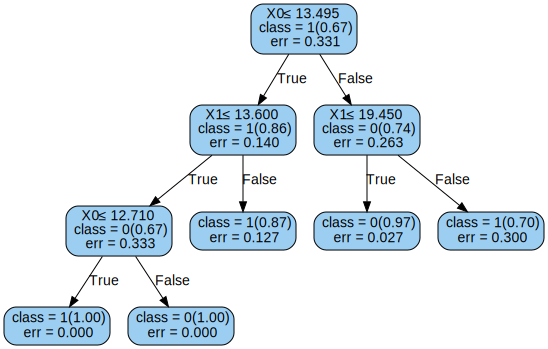

In [18]:
print_dt(DT(x,y, split1, lambda e, err: err > e))

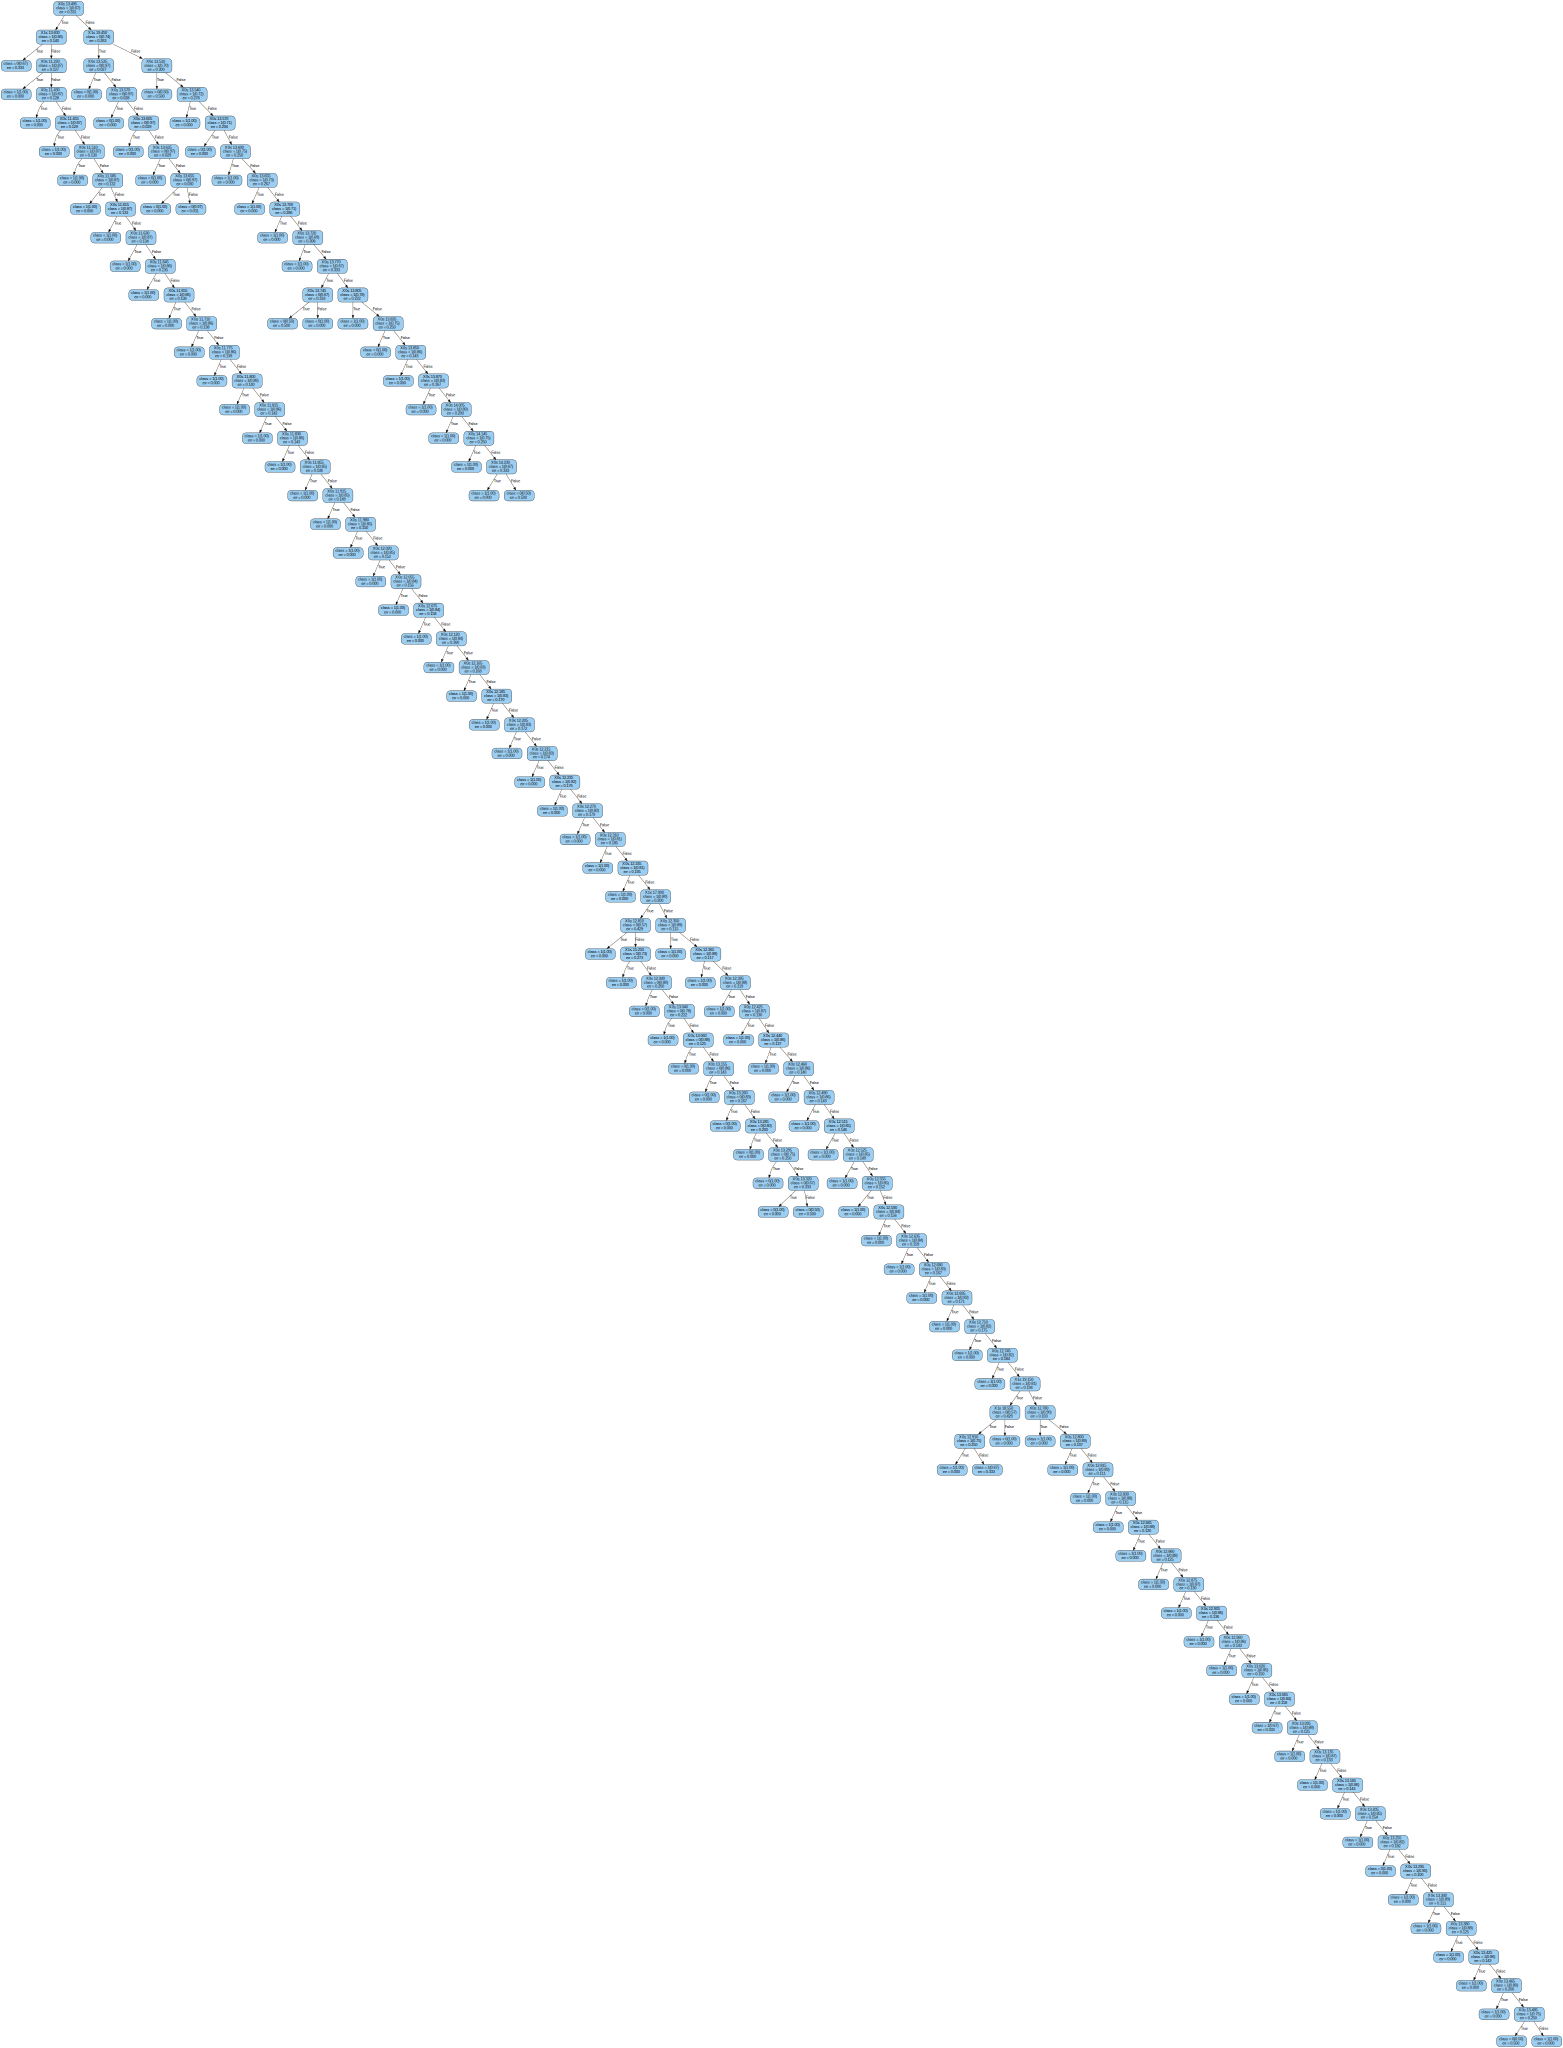

In [19]:
print_dt(DT(x,y, split1, lambda e, err: e > 0))

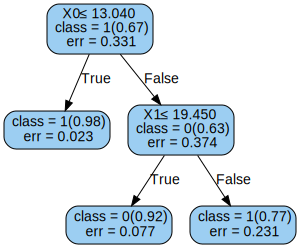

In [20]:
print_dt(DT(x,y, split2, lambda e, err: err > e))

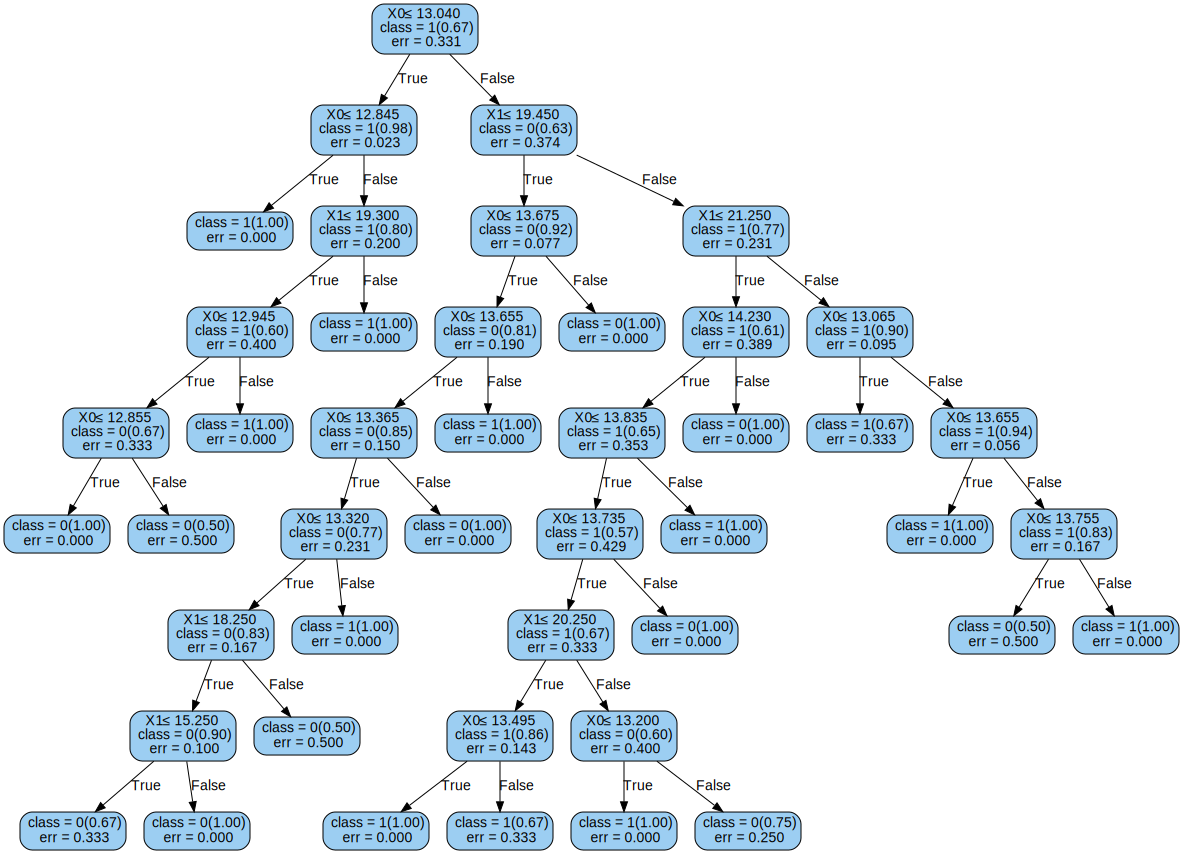

In [21]:
print_dt(DT(x,y, split2, lambda e, err: e > 0))

## Example dataset

In [22]:
x = np.array([[1,1],[2,1],[2,2],[1,2],[1,3],[2,3]])
y = np.array([0,0,0,1,1,1])

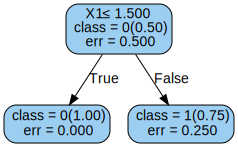

In [23]:
print_dt(DT(x,y, split1, lambda e, err: err > e))

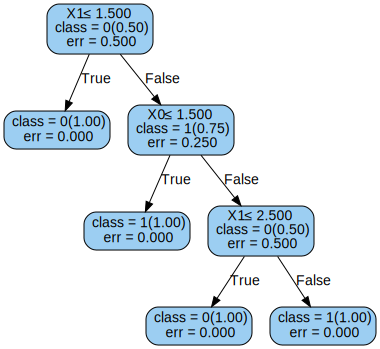

In [24]:
print_dt(DT(x,y, split1, lambda e, err: err > 0))